I have generated a plan to modify the notebook to use FinBERT embeddings instead of scalar sentiment scores. This involves extracting the embeddings, updating the data pipeline to handle high-dimensional vectors, and modifying the model architecture. I will also include a setup for co-finetuning FinBERT, though I'll add checks for memory constraints given the sequence length.

Install Dependencies: Install the transformers library to load the FinBERT model and tokenizer.
Extract FinBERT Embeddings: Load the pre-trained FinBERT model. Process the df_news dataframe to generate 768-dimensional embeddings for each article. Aggregate these embeddings by stock and date (e.g., using mean pooling) to create a daily sentiment vector.
Update Data Processing: Modify the merging logic to join the 768-dimensional sentiment vectors with the stock price data. Update the impute_decay function to handle vector imputation instead of scalar values. Scale the price features while keeping embeddings (or normalizing them separately) and create time-series sequences.
Define Transformer Model (Frozen Embeddings): Update the TimeSeriesTransformer class to accept the new input dimension (3 price features + 768 embedding features). This model will use the pre-computed frozen embeddings.
Define Co-Finetuning Model Architecture: Create a new model class FinBERT_TimeSeries_Model that integrates the FinBERT module directly. This class will accept tokenized text inputs and price sequences, allowing for end-to-end fine-tuning of FinBERT weights. (Note: This will be structured to allow toggling between frozen and unfrozen states).
Train and Evaluate: Set up the training loop to train the modified transformer using the frozen embeddings. Evaluate the performance on the test set and visualize the predictions.
Final Task: Summarize the changes made to the architecture and the results of using embeddings versus the original scalar approach.

# Setup

## Install

In [ ]:
!pip install awswrangler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 148.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.8 MB/s eta 0:00:00


## Import

In [ ]:
import pandas as pd
import awswrangler as wr
import boto3
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import os

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

## Constants

In [ ]:
# --- IMPORTANT: Set these variables before running ---
AWS_REGION = 'us-east-2'
S3_STAGING_DIR = 's3://cs230-market-data-2025/athena-query-results/'
ATHENA_DB = 'cs230_finance_data'
# Querying more data for a small training run
# SQL_QUERY = "SELECT concatarticles1, concatarticles2, vol_1_vs_2 FROM paired_vixy_w_titles_v3 WHERE vol_1_vs_2 is not null ORDER BY RAND() LIMIT 10000"
# SQL_QUERY = "SELECT concatarticles1, concatarticles2, open_lead_close_lag_change_pct_bucket1 as bucket1, open_lead_close_lag_change_pct_bucket2 as bucket2, samebucket_open_lead_close_lag_change_pct as samebucket FROM paired_vixy_w_titles_dedupped ORDER BY RAND() LIMIT 10000"
SQL_QUERY_NEWS = "SELECT * FROM fnspid_nasdaq_news_top5_summaries"
SQL_QUERY_STOCKS = "SELECT * FROM fnspid_stock_prices_top5"

SEQ_LEN = 50 # Small for this dummy data, use 30 or 60 for real usage
FUTURE_LEN = 3

# ----------------------------------------------------


## Connect AWS

In [ ]:
# --- AWS Authentication for Colab ---
# Prompt for AWS credentials
aws_access_key_id = getpass('Enter AWS Access Key ID: ')
aws_secret_access_key = getpass('Enter AWS Secret Access Key: ')


Enter AWS Access Key ID: ··········
Enter AWS Secret Access Key: ··········


# Preprocessing

## Read data from aws

In [ ]:


print(f"\n--- Step 3: Configuration set for {ATHENA_DB} ---")
print(f"--- Step 4: Querying Data ---")
print(f"Querying data from {ATHENA_DB}....")

# Define df in a wider scope
df_news = None
df_stocks = None

try:
    # Create a boto3 session with the provided credentials
    session = boto3.Session(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name=AWS_REGION,
    )

    # Run the query and load results into a Pandas DataFrame
    df_news = wr.athena.read_sql_query(
        sql=SQL_QUERY_NEWS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )

    df_stocks = wr.athena.read_sql_query(
        sql=SQL_QUERY_STOCKS,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )
    SQL_QUERY_STOCKS

    print("\nQuery successful! Data loaded into DataFrame.")



except Exception as e:
    print(f"\nAn error occurred:")
    print(e)


--- Step 3: Configuration set for cs230_finance_data ---
--- Step 4: Querying Data ---
Querying data from cs230_finance_data....



Query successful! Data loaded into DataFrame.


In [ ]:
df_news

,timestamp,article_title,stock_symbol,url,publisher,author,article,lsa_summary,luhn_summary,textrank_summary,lexrank_summary
0,2023-06-29,"GLOBAL MARKETS-Stocks in the summer swing, yen...",AAPL,https://www.nasdaq.com/articles/global-markets...,,,"By Marc Jones LONDON, June 29 (Reuters) - Worl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl..."
1,2023-06-29,"Google Was Just Downgraded, But This Could Be ...",AAPL,https://www.nasdaq.com/articles/google-was-jus...,,,After watching their shares rally by more than...,This will especially be the case given they ge...,This will especially be the case given they ge...,This will especially be the case given they ge...,This will especially be the case given they ge...
2,2023-06-29,GLOBAL MARKETS-Stocks shrug off inflation angs...,AAPL,https://www.nasdaq.com/articles/global-markets...,,,"By Marc Jones LONDON, June 29 (Reuters) - Worl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl...","Overnight, U.S. share markets had ended broadl..."
3,2023-06-29,Familiar Catalyst Could Lift Stocks in Second ...,AAPL,https://www.nasdaq.com/articles/familiar-catal...,,,Artificial intelligence (AIs) stocks and the r...,"“The 2nd, 3rd, and 4th derivatives of this AI ...","“The 2nd, 3rd, and 4th derivatives of this AI ...","“The 2nd, 3rd, and 4th derivatives of this AI ...","“The 2nd, 3rd, and 4th derivatives of this AI ..."
4,2023-06-29,7 Top Growth Stocks to Watch for H2 2023,AAPL,https://www.nasdaq.com/articles/7-top-growth-s...,,,"InvestorPlace - Stock Market News, Stock Advic...","Apple (NASDAQ:AAPL), the largest company in th...",Apple (AAPL) Source: Eric Broder Van Dyke / Sh...,"Apple (NASDAQ:AAPL), the largest company in th...","Apple (NASDAQ:AAPL), the largest company in th..."
...,...,...,...,...,...,...,...,...,...,...,...
39821,2023-10-03,US STOCKS-Wall St slides as Treasury yields ex...,AAPL,https://www.nasdaq.com/articles/us-stocks-wall...,,,"For a Reuters live blog on U.S., UK and Europe...",Yields on 10-year and 30-year U.S. government ...,Yields on 10-year and 30-year U.S. government ...,Yields on 10-year and 30-year U.S. government ...,Yields on 10-year and 30-year U.S. government ...
39822,2023-10-03,Better Buy: Amazon vs. Apple,AAPL,https://www.nasdaq.com/articles/better-buy%3A-...,,,Tech stocks made a solid recovery this year af...,"As a result, investor excitement has sent shar...","As a result, investor excitement has sent shar...","As a result, investor excitement has sent shar...","As a result, investor excitement has sent shar..."
39823,2023-10-03,"HMD starts making Nokia phones in Europe, laun...",AAPL,https://www.nasdaq.com/articles/hmd-starts-mak...,,,"By Paul Sandle LONDON, Oct 3 (Reuters) - HMD G...","By Paul Sandle LONDON, Oct 3 (Reuters) - HMD G...","By Paul Sandle LONDON, Oct 3 (Reuters) - HMD G...","By Paul Sandle LONDON, Oct 3 (Reuters) - HMD G...","By Paul Sandle LONDON, Oct 3 (Reuters) - HMD G..."
39824,2023-10-03,US STOCKS-Futures fall as 10-year yields hit f...,AAPL,https://www.nasdaq.com/articles/us-stocks-futu...,,,By Ankika Biswas and Shashwat Chauhan Oct 3 (R...,Megacap growth stocks were largely mixed in Tu...,Megacap growth stocks were largely mixed in Tu...,Megacap growth stocks were largely mixed in Tu...,Megacap growth stocks were largely mixed in Tu...


## Process stock price

In [ ]:
df = df_stocks.copy()
df['date'] = pd.to_datetime(df['date']).dt.normalize()

In [ ]:
# Helper function to create sequences
def create_sequences(features, target, lookback=50, horizon=3):
    X, y = [], []
    # We create sequences of length 'lookback'
    # The target is 'horizon' steps after the sequence ends
    # Sequence ends at index i + lookback - 1
    # Target index is (i + lookback - 1) + horizon
    for i in range(len(features) - lookback - horizon + 1):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback + horizon - 1])
    return np.array(X), np.array(y)

print("Helper function 'create_sequences' defined.")
# The actual data generation loop has been moved to the Sentiment Fusion section
# to avoid doing the work twice.

Helper function 'create_sequences' defined.


# Daily Sentiment Embedding


## Install Dependencies

### Subtask:
Install the `transformers` library to load the FinBERT model and tokenizer.


**Reasoning**:
Install the transformers library to enable loading the FinBERT model and tokenizer.



In [ ]:
!pip install transformers

## Extract FinBERT Embeddings

### Subtask:
Generate 768-dimensional embeddings for the news summaries using the pre-trained FinBERT model and aggregate them by stock and date.


**Reasoning**:
Implement the embedding extraction process using FinBERT. This involves loading the model, processing the news summaries in batches to extract CLS token embeddings, and aggregating them by stock and date. This directly follows the provided instructions.



In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Models and Tokenizers
# FinBERT
FINBERT_NAME = "ProsusAI/finbert"
tokenizer_fb = BertTokenizer.from_pretrained(FINBERT_NAME)
model_fb = BertModel.from_pretrained(FINBERT_NAME)
model_fb.to(device)
model_fb.eval()

# SentenceBERT (using AutoModel for compatibility)
SBERT_NAME = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer_sb = AutoTokenizer.from_pretrained(SBERT_NAME)
model_sb = AutoModel.from_pretrained(SBERT_NAME)
model_sb.to(device)
model_sb.eval()

# 3. Data Preparation
# Check if df_news exists in global scope
if 'df_news' not in globals():
    raise ValueError("df_news is not defined. Please ensure the data loading step was successful.")

summaries = df_news['lsa_summary'].fillna("").astype(str).tolist()

# 4. Generate Embeddings
all_finbert_embeddings = []
all_sbert_embeddings = []
batch_size = 32

print(f"Generating embeddings for {len(summaries)} articles...")

for i in tqdm(range(0, len(summaries), batch_size)):
    batch_texts = summaries[i : i + batch_size]

    # --- FinBERT Inference ---
    inputs_fb = tokenizer_fb(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs_fb = model_fb(**inputs_fb)
        # CLS token is at index 0
        cls_embeddings = outputs_fb.last_hidden_state[:, 0, :].cpu().numpy()
        all_finbert_embeddings.append(cls_embeddings)

    # --- SentenceBERT Inference ---
    inputs_sb = tokenizer_sb(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs_sb = model_sb(**inputs_sb)
        # Mean Pooling for SentenceBERT
        token_embeddings = outputs_sb.last_hidden_state
        attention_mask = inputs_sb['attention_mask']

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

        mean_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
        all_sbert_embeddings.append(mean_embeddings)

# 5. Create DataFrame with Object Columns
if all_finbert_embeddings and all_sbert_embeddings:
    fb_matrix = np.vstack(all_finbert_embeddings)
    sb_matrix = np.vstack(all_sbert_embeddings)

    # Create DataFrame
    embedding_df = pd.DataFrame()

    # Add metadata
    embedding_df['stock_symbol'] = df_news['stock_symbol'].values

    date_col = 'timestamp' if 'timestamp' in df_news.columns else 'date'
    embedding_df['date'] = pd.to_datetime(df_news[date_col]).dt.normalize()

    # Add embeddings as columns containing the vectors
    # list(matrix) converts the 2D array into a list of 1D arrays
    embedding_df['finbert_embedding'] = list(fb_matrix)
    embedding_df['sbert_embedding'] = list(sb_matrix)

    # Group by stock and date
    # print("Aggregating embeddings...")
    # sentiment_embeddings = embedding_df.groupby(['stock_symbol', 'date']).mean().reset_index()

    # print(f"Sentiment embeddings shape: {sentiment_embeddings.shape}")
    # print(sentiment_embeddings.head())

    print("Created 'embedding_df' with separate columns for FinBERT and SBERT embeddings.")
    print(f"Shape: {embedding_df.shape}")
    print(embedding_df.head())

else:
    print("No embeddings generated.")

# embedding_df

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Generating embeddings for 39826 articles...


100%|██████████| 1245/1245 [03:25<00:00,  6.05it/s]


Created 'embedding_df' with separate columns for FinBERT and SBERT embeddings.
Shape: (39826, 4)
  stock_symbol       date                                  finbert_embedding  \
0         AAPL 2023-06-29  [1.2461818, -0.9022974, 0.083544806, 0.0297611...   
1         AAPL 2023-06-29  [0.26454777, -0.26676956, -0.28242734, -0.5242...   
2         AAPL 2023-06-29  [0.3196243, -0.41617492, 0.5074514, -0.1596219...   
3         AAPL 2023-06-29  [0.37117305, 0.3475782, -0.71400297, 0.0793063...   
4         AAPL 2023-06-29  [0.35676628, 0.15744025, -0.4031942, -0.518251...   

                                     sbert_embedding  
0  [0.023689171, 0.03685065, 0.077800296, 0.20099...  
1  [-0.20797989, -0.18259199, 0.13002439, -0.0439...  
2  [0.0737528, -0.010322308, 0.009223388, 0.25496...  
3  [-0.1491526, -0.17198914, -0.031726357, 0.0262...  
4  [0.1929033, -0.19234574, -0.05480871, 0.027058...  


In [ ]:
embedding_df

,stock_symbol,date,finbert_embedding,sbert_embedding
0,AAPL,2023-06-29,"[1.2461818, -0.9022974, 0.083544806, 0.0297611...","[0.023689171, 0.03685065, 0.077800296, 0.20099..."
1,AAPL,2023-06-29,"[0.26454777, -0.26676956, -0.28242734, -0.5242...","[-0.20797989, -0.18259199, 0.13002439, -0.0439..."
2,AAPL,2023-06-29,"[0.3196243, -0.41617492, 0.5074514, -0.1596219...","[0.0737528, -0.010322308, 0.009223388, 0.25496..."
3,AAPL,2023-06-29,"[0.37117305, 0.3475782, -0.71400297, 0.0793063...","[-0.1491526, -0.17198914, -0.031726357, 0.0262..."
4,AAPL,2023-06-29,"[0.35676628, 0.15744025, -0.4031942, -0.518251...","[0.1929033, -0.19234574, -0.05480871, 0.027058..."
...,...,...,...,...
39821,AAPL,2023-10-03,"[-0.27227864, -0.13498002, 0.53311056, -0.4836...","[-0.08349175, -0.15941696, 0.047384545, 0.1602..."
39822,AAPL,2023-10-03,"[-0.12686643, 0.12727113, -0.5904021, -0.35517...","[0.083013624, -0.034435898, 0.03657243, 0.0700..."
39823,AAPL,2023-10-03,"[0.46635714, -0.26151365, -0.5455282, -0.50366...","[-0.18994795, 0.12858507, 0.18641941, -0.21409..."
39824,AAPL,2023-10-03,"[-0.13096038, -0.27886027, 0.47714946, -0.5628...","[-0.08141625, -0.05169062, 0.16020063, 0.11944..."


## Save and Load Embeddings

### Subtask:
Save the generated embeddings to a CSV file for persistence and implement loading logic.


In [ ]:
# import os
# import pandas as pd

# # # Check if sentiment_embeddings exists in memory
# if 'embedding_df' in globals():
#     print("Saving embeddings to CSV...")
#     embedding_df.to_csv('embedding_df.csv', index=False)
#     print("Embeddings saved to 'embedding_df.csv'.")
# else:
#     print("Variable 'embedding_df' not found in memory. Checking for file...")
#     if os.path.exists('embedding_df.csv'):
#         print("Loading embeddings from 'embedding_df.csv'...")
#         embedding_df = pd.read_csv('embedding_df.csv')
#         embedding_df['date'] = pd.to_datetime(embedding_df['date'])
#         print("Embeddings loaded successfully.")
#     else:
#         print("Error: 'embedding_df.csv' not found. Please run the embedding generation step first.")

# # Verify
# if 'embedding_df' in globals():
#     print(f"embedding_df Shape: {embedding_df.shape}")
#     print(embedding_df.head())

Saving embeddings to CSV...
Embeddings saved to 'embedding_df.csv'.
Sentiment Embeddings Shape: (39826, 4)
  stock_symbol       date                                  finbert_embedding  \
0         AAPL 2023-06-29  [1.2461818, -0.9022974, 0.083544806, 0.0297611...   
1         AAPL 2023-06-29  [0.6943131, -1.0558215, 0.64852285, 0.06303172...   
2         AAPL 2023-06-29  [0.14655472, 0.16593164, -0.5885261, 0.0798830...   
3         AAPL 2023-06-29  [0.26454777, -0.26676956, -0.28242734, -0.5242...   
4         AAPL 2023-06-29  [0.3196243, -0.41617492, 0.5074514, -0.1596219...   

                                     sbert_embedding  
0  [0.023689171, 0.03685065, 0.077800296, 0.20099...  
1  [0.07605356, -0.1104228, -0.024100639, 0.10492...  
2  [-0.11893029, -0.029719528, -0.016160678, 0.03...  
3  [-0.20797989, -0.18259199, 0.13002439, -0.0439...  
4  [0.0737528, -0.010322308, 0.009223388, 0.25496...  


**Reasoning**:
I will merge the stock data with the generated sentiment embeddings, using a forward fill strategy to impute missing sentiment values as permitted by the instructions. Then, I will scale the numerical stock features and generate time-series sequences for training and testing.



Below cell requires more than 160GB system ram

In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from tqdm.notebook import tqdm

# # --- Configuration ---
# lookback = 50
# horizon = 3
# MAX_NEWS = 30  # Max articles per day to consider (truncate/pad)
# SBERT_DIM = 384
# FINBERT_DIM = 768

# # 1. Prepare Daily News Bags
# # We need to map (stock, date) -> (sbert_bag, finbert_bag)
# print("Grouping news by stock and date...")

# # Ensure date is datetime
# embedding_df['date'] = pd.to_datetime(embedding_df['date']).dt.normalize()

# # Group and aggregate to lists
# daily_groups = embedding_df.groupby(['stock_symbol', 'date'])
# daily_news_map = {}

# for (symbol, date), group in tqdm(daily_groups, desc="Processing Days"):
#     # Extract lists of embeddings
#     sb_list = group['sbert_embedding'].tolist()
#     fb_list = group['finbert_embedding'].tolist()

#     # Convert to arrays for efficient handling later
#     daily_news_map[(symbol, date)] = (sb_list, fb_list)

# # 2. Stock ID Mapping (for q_i lookup)
# unique_stocks = df_stocks['stock_symbol'].unique()
# stock_to_idx = {symbol: i for i, symbol in enumerate(unique_stocks)}
# print(f"Stock Mappings: {stock_to_idx}")

# # 3. Sequence Generation Helper
# def create_complex_sequences(prices, sbert_bags, finbert_bags, masks, stock_idx, target, lookback, horizon):
#     X_p, X_sb, X_fb, X_m, X_idx, y = [], [], [], [], [], []

#     for i in range(len(prices) - lookback - horizon + 1):
#         X_p.append(prices[i : i + lookback])
#         X_sb.append(sbert_bags[i : i + lookback])
#         X_fb.append(finbert_bags[i : i + lookback])
#         X_m.append(masks[i : i + lookback])
#         X_idx.append(stock_idx) # Constant for the sequence
#         y.append(target[i + lookback + horizon - 1])

#     return np.array(X_p), np.array(X_sb), np.array(X_fb), np.array(X_m), np.array(X_idx), np.array(y)

# # 4. Padding Helper
# def pad_bag(sbert_list, finbert_list, max_len=MAX_NEWS):
#     n = len(sbert_list)
#     if n == 0:
#         return np.zeros((max_len, SBERT_DIM)), np.zeros((max_len, FINBERT_DIM)), np.zeros(max_len)

#     # Truncate
#     if n > max_len:
#         sbert_list = sbert_list[:max_len]
#         finbert_list = finbert_list[:max_len]
#         n = max_len

#     # Stack
#     sb_stack = np.array(sbert_list)
#     fb_stack = np.array(finbert_list)

#     # Pad
#     pad_size = max_len - n
#     mask = np.concatenate([np.ones(n), np.zeros(pad_size)])

#     if pad_size > 0:
#         sb_padded = np.pad(sb_stack, ((0, pad_size), (0, 0)), 'constant')
#         fb_padded = np.pad(fb_stack, ((0, pad_size), (0, 0)), 'constant')
#     else:
#         sb_padded = sb_stack
#         fb_padded = fb_stack

#     return sb_padded, fb_padded, mask

# # 5. Main Processing Loop
# print("Generating sequences with bag-of-embeddings...")

# X_train_data = {'price': [], 'sbert': [], 'finbert': [], 'mask': [], 'sid': []}
# y_train_all = []

# X_test_data = {'price': [], 'sbert': [], 'finbert': [], 'mask': [], 'sid': []}
# y_test_all = []

# scalers = {}
# price_cols = ['open', 'close', 'volume']

# df['date'] = pd.to_datetime(df['date']).dt.normalize()

# for symbol in unique_stocks:
#     stock_idx = stock_to_idx[symbol]
#     group = df[df['stock_symbol'] == symbol].sort_values('date').copy()

#     # Align Data
#     dates = group['date'].values
#     raw_prices = group[price_cols].values

#     # Prepare aligned lists for this stock's history
#     aligned_sbert = []
#     aligned_finbert = []
#     aligned_masks = []

#     # Forward Fill Logic for Embeddings
#     last_valid_sb = []
#     last_valid_fb = []

#     for d in dates:
#         # d is numpy datetime64, convert to pandas timestamp for lookup
#         ts = pd.Timestamp(d)

#         if (symbol, ts) in daily_news_map:
#             sb, fb = daily_news_map[(symbol, ts)]
#             last_valid_sb, last_valid_fb = sb, fb
#         # else: use last_valid (Forward Fill)

#         # Pad the current valid bag
#         sb_pad, fb_pad, mask = pad_bag(last_valid_sb, last_valid_fb)
#         aligned_sbert.append(sb_pad)
#         aligned_finbert.append(fb_pad)
#         aligned_masks.append(mask)

#     aligned_sbert = np.array(aligned_sbert)
#     aligned_finbert = np.array(aligned_finbert)
#     aligned_masks = np.array(aligned_masks)

#     # Split Train/Test
#     split_idx = int(len(raw_prices) * 0.8)

#     # Scaling
#     scaler = MinMaxScaler()
#     train_prices = scaler.fit_transform(raw_prices[:split_idx])
#     test_prices = scaler.transform(raw_prices[split_idx:])
#     scalers[symbol] = scaler

#     # Create Sequences
#     # Train
#     res_train = create_complex_sequences(
#         train_prices, aligned_sbert[:split_idx], aligned_finbert[:split_idx], aligned_masks[:split_idx],
#         stock_idx, train_prices[:, 1], lookback, horizon # Target is Close price
#     )
#     if len(res_train[0]) > 0:
#         X_train_data['price'].append(res_train[0])
#         X_train_data['sbert'].append(res_train[1])
#         X_train_data['finbert'].append(res_train[2])
#         X_train_data['mask'].append(res_train[3])
#         X_train_data['sid'].append(res_train[4])
#         y_train_all.append(res_train[5])

#     # Test
#     res_test = create_complex_sequences(
#         test_prices, aligned_sbert[split_idx:], aligned_finbert[split_idx:], aligned_masks[split_idx:],
#         stock_idx, test_prices[:, 1], lookback, horizon
#     )
#     if len(res_test[0]) > 0:
#         X_test_data['price'].append(res_test[0])
#         X_test_data['sbert'].append(res_test[1])
#         X_test_data['finbert'].append(res_test[2])
#         X_test_data['mask'].append(res_test[3])
#         X_test_data['sid'].append(res_test[4])
#         y_test_all.append(res_test[5])

# # Concatenate All
# def concat_dict(d):
#     return {k: np.concatenate(v, axis=0) for k, v in d.items()}

# X_train = concat_dict(X_train_data)
# y_train = np.concatenate(y_train_all, axis=0)

# X_test = concat_dict(X_test_data)
# y_test = np.concatenate(y_test_all, axis=0)

# print("Processing Complete.")
# print(f"X_train shapes: Price {X_train['price'].shape}, SBERT {X_train['sbert'].shape}")
# print(f"X_train mask: {X_train['mask'].shape}, ID: {X_train['sid'].shape}")

Grouping news by stock and date...


Processing Days:   0%|          | 0/3922 [00:00<?, ?it/s]

Stock Mappings: {'aapl': 0, 'amzn': 1, 'goog': 2, 'msft': 3, 'nvda': 4}
Generating sequences with bag-of-embeddings...


# Task
Read the content of "/content/cleaned_a_sen_transformer.py" to identify and extract the specific 4-layer vanilla transformer class definition. Then, based on this architecture, redefine the `TimeSeriesTransformer` class to accept the 771-dimensional input (frozen embeddings + price features) and creating a new `FinBERT_TimeSeries_Model` class that integrates the FinBERT module for co-finetuning.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math

# # 1. Positional Encoding
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return x + self.pe[:, :x.size(1), :]

# # 2. Learnable Stock Attention Module
# class StockNewsAttention(nn.Module):
#     def __init__(self, num_stocks, sbert_dim, finbert_dim):
#         super(StockNewsAttention, self).__init__()
#         # Learnable Query Vectors (q_i) for each stock
#         # Shape: (Num_Stocks, SBERT_DIM)
#         self.stock_queries = nn.Embedding(num_stocks, sbert_dim)

#         self.scale = math.sqrt(sbert_dim)

#     def forward(self, sbert_seq, finbert_seq, masks, stock_ids):
#         """
#         sbert_seq: (Batch, Seq_Len, Max_News, SBERT_Dim) - Keys
#         finbert_seq: (Batch, Seq_Len, Max_News, FinBERT_Dim) - Values
#         masks: (Batch, Seq_Len, Max_News) - 1 for article, 0 for pad
#         stock_ids: (Batch, Seq_Len) - Stock ID for each step (usually same across seq)
#         """
#         batch_size, seq_len, max_news, _ = sbert_seq.shape

#         # Get q_i for the batch
#         # stock_ids shape: (Batch, Seq_Len)
#         # queries shape: (Batch, Seq_Len, SBERT_Dim)
#         queries = self.stock_queries(stock_ids)

#         # Expand queries to match max_news dimension for broadcasting
#         # We want to dot product q_i with every article embedding
#         # q: (B, S, 1, Dim), k: (B, S, N, Dim)
#         queries = queries.unsqueeze(2)

#         # Calculate Attention Scores: (q . k)
#         # (B, S, 1, Dim) * (B, S, N, Dim) -> Sum over Dim -> (B, S, N)
#         scores = torch.sum(queries * sbert_seq, dim=-1) / self.scale

#         # Apply Mask (set padded positions to -infinity)
#         # masks is (B, S, N). 0 means pad.
#         scores = scores.masked_fill(masks == 0, -1e9)

#         # Softmax over the News dimension
#         attn_weights = F.softmax(scores, dim=-1)
#         # Shape: (Batch, Seq_Len, Max_News)

#         # Expand weights for multiplication with values
#         # (B, S, N, 1)
#         attn_weights_expanded = attn_weights.unsqueeze(-1)

#         # Weighted Sum of FinBERT embeddings
#         # (B, S, N, 1) * (B, S, N, FinDim) -> (B, S, N, FinDim) -> Sum over N -> (B, S, FinDim)
#         weighted_avg = torch.sum(attn_weights_expanded * finbert_seq, dim=2)

#         return weighted_avg, attn_weights

# # 3. Main Model Integration
# class AttentionTimeSeriesTransformer(nn.Module):
#     def __init__(self, num_stocks, sbert_dim, finbert_dim, price_dim, d_model, num_heads, num_layers, output_dim, dropout=0.1):
#         super(AttentionTimeSeriesTransformer, self).__init__()

#         # Attention Module
#         self.news_attention = StockNewsAttention(num_stocks, sbert_dim, finbert_dim)

#         # Feature Fusion
#         # Input to Transformer = Price_Features + Aggregated_Sentiment (FinBERT_Dim)
#         combined_input_dim = price_dim + finbert_dim
#         self.input_projection = nn.Linear(combined_input_dim, d_model)
#         self.activation = nn.ReLU()

#         # Transformer
#         self.pos_encoder = PositionalEncoding(d_model)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, nhead=num_heads, batch_first=True, dropout=dropout, norm_first=True
#         )
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         self.decoder = nn.Linear(d_model, output_dim)

#     def forward(self, price_seq, sbert_seq, finbert_seq, masks, stock_ids):
#         # 1. Aggregate News
#         # sentiment_embedding is the "Attention Weighted Average" user asked for
#         sentiment_embedding, _ = self.news_attention(sbert_seq, finbert_seq, masks, stock_ids)

#         # 2. Combine with Price
#         # price: (B, S, P), sentiment: (B, S, F) -> (B, S, P+F)
#         combined_features = torch.cat([price_seq, sentiment_embedding], dim=-1)

#         # 3. Transformer Steps
#         x = self.input_projection(combined_features) * math.sqrt(self.input_projection.out_features)
#         x = self.activation(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x)

#         # Output (Last step)
#         x = x[:, -1, :]
#         return self.decoder(x)

# print("Defined 'AttentionTimeSeriesTransformer' with learnable stock-specific query vectors.")

Defined 'AttentionTimeSeriesTransformer' with learnable stock-specific query vectors.


# Task
Optimize the notebook's memory usage by refactoring the data pipeline. First, update cell `8100fd7f` to save/load the embedding dataframe using `pickle` to handle the list-of-floats correctly. Next, rewrite cell `d782c2b7` to preprocess stock data into linear arrays (List of Dicts) instead of pre-generating all sliding window sequences in memory. Then, modify cell `9fbe8a42` to implement a `LazyStockDataset` class that generates sequences on-the-fly during training. Finally, execute the training loop to verify memory stability.

## Optimize Save/Load

### Subtask:
Update the saving and loading mechanism to use pickle for efficient handling of list-based columns.


**Reasoning**:
I will implement the save and load logic using pickle as requested. This ensures that the list-based embedding columns are preserved correctly without needing string parsing when reloaded.



In [ ]:
import os
import pandas as pd

# Check if embedding_df exists in memory
if 'embedding_df' in globals():
    print("Saving embeddings to Pickle...")
    embedding_df.to_pickle('embedding_df.pkl')
    print("Embeddings saved to 'embedding_df.pkl'.")
else:
    print("Variable 'embedding_df' not found in memory. Checking for file...")
    if os.path.exists('embedding_df.pkl'):
        print("Loading embeddings from 'embedding_df.pkl'...")
        embedding_df = pd.read_pickle('embedding_df.pkl')
        print(f"Embeddings loaded successfully. Shape: {embedding_df.shape}")
    else:
        print("Error: 'embedding_df.pkl' not found. Please run the embedding generation step first.")

Saving embeddings to Pickle...
Embeddings saved to 'embedding_df.pkl'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Reasoning**:
I will rewrite the preprocessing logic to store data in linear arrays (List of Dicts) instead of generating all sliding window sequences upfront. This significantly reduces memory usage by avoiding duplication of overlapping sequences. I'll implement a loop that processes each stock, handles embedding alignment/imputation, scales the features, and splits the data into training and testing sets stored as dictionaries.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# --- Configuration ---
lookback = 50
horizon = 3
MAX_NEWS = 30
SBERT_DIM = 384
FINBERT_DIM = 768

# Data Containers
train_data_store = []
test_data_store = []
scalers = {}

# Check dependencies to avoid hard crash if previous steps failed
if 'embedding_df' not in globals() or 'df' not in globals():
    print("Warning: 'embedding_df' or 'df' not found. The code below requires these variables to be loaded.")
    print("Please run the Data Loading and Embedding Generation steps first.")
else:
    # 1. Prepare Daily News Map
    print("Grouping news by stock and date...")
    # Ensure date is datetime
    embedding_df['date'] = pd.to_datetime(embedding_df['date']).dt.normalize()

    daily_groups = embedding_df.groupby(['stock_symbol', 'date'])
    # Map (symbol, date) -> (list of sbert, list of finbert)
    daily_news_map = {
        k: (g['sbert_embedding'].tolist(), g['finbert_embedding'].tolist())
        for k, g in daily_groups
    }

    # 2. Helper: Pad Bag
    def pad_bag(sbert_list, finbert_list, max_len=MAX_NEWS):
        n = len(sbert_list)
        if n == 0:
            return np.zeros((max_len, SBERT_DIM)), np.zeros((max_len, FINBERT_DIM)), np.zeros(max_len)

        # Truncate if necessary
        n = min(n, max_len)
        sbert_list = sbert_list[:n]
        finbert_list = finbert_list[:n]

        # Stack
        sb_stack = np.array(sbert_list)
        fb_stack = np.array(finbert_list)

        # Pad
        pad_size = max_len - n
        mask = np.concatenate([np.ones(n), np.zeros(pad_size)])

        if pad_size > 0:
            sb_padded = np.pad(sb_stack, ((0, pad_size), (0, 0)), 'constant')
            fb_padded = np.pad(fb_stack, ((0, pad_size), (0, 0)), 'constant')
        else:
            sb_padded = sb_stack
            fb_padded = fb_stack

        return sb_padded, fb_padded, mask

    # 3. Process Each Stock
    # Ensure df has date normalized
    df['date'] = pd.to_datetime(df['date']).dt.normalize()

    unique_stocks = df['stock_symbol'].unique()
    stock_to_idx = {symbol: i for i, symbol in enumerate(unique_stocks)}
    price_cols = ['open', 'close', 'volume']

    print("Processing stocks into linear arrays...")

    for symbol in tqdm(unique_stocks):
        stock_idx = stock_to_idx[symbol]
        group = df[df['stock_symbol'] == symbol].sort_values('date').copy()

        dates = group['date'].values
        raw_prices = group[price_cols].values

        # Align News (Forward Fill Logic)
        aligned_sbert = []
        aligned_finbert = []
        aligned_masks = []

        # Initialize with empty/zeros or search for first valid?
        # We'll start empty. Forward fill will pick up once valid data appears.
        last_sb, last_fb = [], []

        for d in dates:
            ts = pd.Timestamp(d)
            if (symbol, ts) in daily_news_map:
                last_sb, last_fb = daily_news_map[(symbol, ts)]

            # Pad the current valid bag (or last valid)
            sb_pad, fb_pad, mask = pad_bag(last_sb, last_fb)
            aligned_sbert.append(sb_pad)
            aligned_finbert.append(fb_pad)
            aligned_masks.append(mask)

        # Convert lists to numpy arrays for this stock
        aligned_sbert = np.array(aligned_sbert, dtype=np.float32)
        aligned_finbert = np.array(aligned_finbert, dtype=np.float32)
        aligned_masks = np.array(aligned_masks, dtype=np.float32)

        # Split Train/Test (80/20)
        split_idx = int(len(raw_prices) * 0.8)

        # Scale Prices
        scaler = MinMaxScaler()
        prices_train = scaler.fit_transform(raw_prices[:split_idx])
        prices_test = scaler.transform(raw_prices[split_idx:])
        scalers[symbol] = scaler

        # Store Linear Data (List of Dicts)
        if len(prices_train) > 0:
            train_data_store.append({
                'symbol': symbol,
                'sid': stock_idx,
                'price': prices_train.astype(np.float32),
                'sbert': aligned_sbert[:split_idx],
                'finbert': aligned_finbert[:split_idx],
                'mask': aligned_masks[:split_idx]
            })

        if len(prices_test) > 0:
            test_data_store.append({
                'symbol': symbol,
                'sid': stock_idx,
                'price': prices_test.astype(np.float32),
                'sbert': aligned_sbert[split_idx:],
                'finbert': aligned_finbert[split_idx:],
                'mask': aligned_masks[split_idx:]
            })

    print(f"Processed {len(train_data_store)} stocks for training.")
    if len(train_data_store) > 0:
        print(f"Example Train Price Shape: {train_data_store[0]['price'].shape}")

Grouping news by stock and date...
Processing stocks into linear arrays...


  0%|          | 0/5 [00:00<?, ?it/s]

Processed 5 stocks for training.
Example Train Price Shape: (8681, 3)


Using device: cuda
Initializing Lazy Datasets...
Train samples: 30320, Test samples: 7387
Starting training for 100 epochs...
Epoch [1/100] | Train Loss: 0.050097 | Test Loss: 1.076155
Epoch [2/100] | Train Loss: 0.001524 | Test Loss: 0.834956
Epoch [3/100] | Train Loss: 0.000750 | Test Loss: 0.727424
Epoch [4/100] | Train Loss: 0.000464 | Test Loss: 0.604488
Epoch [5/100] | Train Loss: 0.000363 | Test Loss: 0.567422
Epoch [6/100] | Train Loss: 0.000280 | Test Loss: 0.474399
Epoch [7/100] | Train Loss: 0.000245 | Test Loss: 0.302946
Epoch [8/100] | Train Loss: 0.000231 | Test Loss: 0.252526
Epoch [9/100] | Train Loss: 0.000209 | Test Loss: 0.149278
Epoch [10/100] | Train Loss: 0.000210 | Test Loss: 0.105253
Epoch [11/100] | Train Loss: 0.000198 | Test Loss: 0.065254
Epoch [12/100] | Train Loss: 0.000178 | Test Loss: 0.077856
Epoch [13/100] | Train Loss: 0.000171 | Test Loss: 0.104466
Epoch [14/100] | Train Loss: 0.000162 | Test Loss: 0.098064
Epoch [15/100] | Train Loss: 0.000156 | Tes

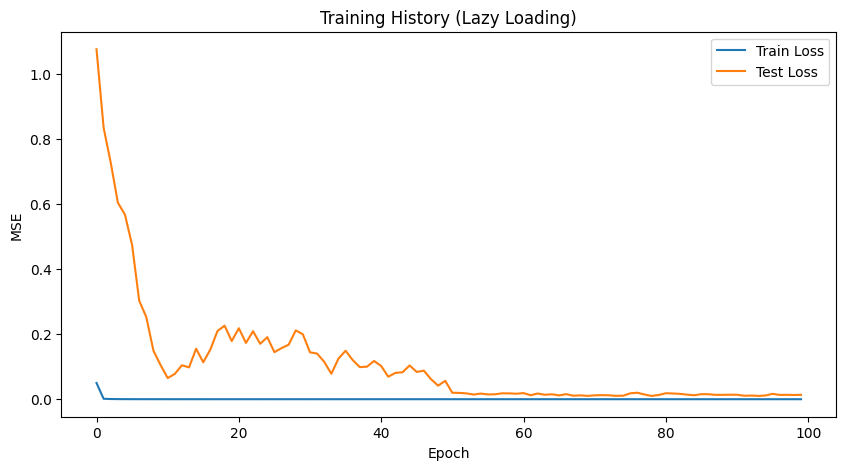

In [ ]:
import torch
import sys

# --- RECOVERY FROM PREVIOUS CELL ERROR ---
# The previous cell execution corrupted the module state by deleting torch._dynamo modules
# but leaving torch.compiler loaded. This causes a collision when torch._dynamo is re-imported.
# We explicitly remove the colliding artifact from the registry.
try:
    import torch.compiler._cache
    # Access the artifact registry
    registry = torch.compiler._cache.CacheArtifactFactory._artifact_types
    # Remove 'pgo' if it exists to prevent the AssertionError on re-registration
    if 'pgo' in registry:
        print("Cleaning up 'pgo' artifact from registry to allow re-import.")
        del registry['pgo']
except Exception as e:
    print(f"Registry cleanup skipped: {e}")
# -----------------------------------------

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Model Definitions (Ensuring availability) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class StockNewsAttention(nn.Module):
    def __init__(self, num_stocks, sbert_dim, finbert_dim):
        super(StockNewsAttention, self).__init__()
        self.stock_queries = nn.Embedding(num_stocks, sbert_dim)
        self.scale = math.sqrt(sbert_dim)

    def forward(self, sbert_seq, finbert_seq, masks, stock_ids):
        # stock_ids: (Batch, Seq_Len)
        queries = self.stock_queries(stock_ids) # (B, S, Dim)
        queries = queries.unsqueeze(2) # (B, S, 1, Dim)

        # Attention Scores
        scores = torch.sum(queries * sbert_seq, dim=-1) / self.scale # (B, S, N)
        scores = scores.masked_fill(masks == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=-1)

        # Weighted Sum
        attn_weights_expanded = attn_weights.unsqueeze(-1)
        weighted_avg = torch.sum(attn_weights_expanded * finbert_seq, dim=2)
        return weighted_avg, attn_weights

class AttentionTimeSeriesTransformer(nn.Module):
    def __init__(self, num_stocks, sbert_dim, finbert_dim, price_dim, d_model, num_heads, num_layers, output_dim, dropout=0.1):
        super(AttentionTimeSeriesTransformer, self).__init__()
        self.news_attention = StockNewsAttention(num_stocks, sbert_dim, finbert_dim)
        self.input_projection = nn.Linear(price_dim + finbert_dim, d_model)
        self.activation = nn.ReLU()
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True, dropout=dropout, norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, price_seq, sbert_seq, finbert_seq, masks, stock_ids):
        sentiment_embedding, _ = self.news_attention(sbert_seq, finbert_seq, masks, stock_ids)
        combined_features = torch.cat([price_seq, sentiment_embedding], dim=-1)
        x = self.input_projection(combined_features) * math.sqrt(self.input_projection.out_features)
        x = self.activation(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return self.decoder(x[:, -1, :])

# --- 2. Lazy Dataset Implementation ---
class LazyStockDataset(Dataset):
    def __init__(self, data_store, lookback, horizon):
        self.data_store = data_store
        self.lookback = lookback
        self.horizon = horizon
        self.samples_map = []

        # Pre-calculate valid indices
        for stock_i, stock_data in enumerate(data_store):
            n_samples = len(stock_data['price']) - lookback - horizon + 1
            if n_samples > 0:
                # Store (stock_index, start_index_offset, count)
                self.samples_map.append((stock_i, n_samples))

        self.cumulative_counts = np.cumsum([x[1] for x in self.samples_map])
        self.total_samples = self.cumulative_counts[-1] if len(self.cumulative_counts) > 0 else 0

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        # Find which stock this idx belongs to
        bin_idx = np.searchsorted(self.cumulative_counts, idx, side='right')

        if bin_idx == 0:
            stock_internal_idx = idx
            stock_store_idx = self.samples_map[0][0]
        else:
            stock_internal_idx = idx - self.cumulative_counts[bin_idx - 1]
            stock_store_idx = self.samples_map[bin_idx][0]

        data = self.data_store[stock_store_idx]

        # Slicing
        lb = self.lookback
        h = self.horizon
        start = stock_internal_idx
        end = start + lb
        target_idx = end + h - 1

        price_seq = data['price'][start:end]
        sbert_seq = data['sbert'][start:end]
        finbert_seq = data['finbert'][start:end]
        mask_seq = data['mask'][start:end]
        sid = data['sid'] # Scalar
        y = data['price'][target_idx, 1] # Close price target

        return (
            torch.tensor(price_seq, dtype=torch.float32),
            torch.tensor(sbert_seq, dtype=torch.float32),
            torch.tensor(finbert_seq, dtype=torch.float32),
            torch.tensor(mask_seq, dtype=torch.float32),
            torch.tensor(sid, dtype=torch.long),
            torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        )

# --- 3. Training Setup ---
if 'train_data_store' in globals() and len(train_data_store) > 0:
    print("Initializing Lazy Datasets...")
    train_dataset = LazyStockDataset(train_data_store, lookback, horizon)
    test_dataset = LazyStockDataset(test_data_store, lookback, horizon)

    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Model Params
    # Assuming data consistency (using first stock to check dims)
    sample_stock = train_data_store[0]
    num_stocks = max([d['sid'] for d in train_data_store] + [d['sid'] for d in test_data_store]) + 1
    sbert_dim = sample_stock['sbert'].shape[-1]
    finbert_dim = sample_stock['finbert'].shape[-1]
    price_dim = sample_stock['price'].shape[-1]

    model = AttentionTimeSeriesTransformer(
        num_stocks=num_stocks,
        sbert_dim=sbert_dim,
        finbert_dim=finbert_dim,
        price_dim=price_dim,
        d_model=64,
        num_heads=4,
        num_layers=2,
        output_dim=1,
        dropout=0.2
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    # --- 4. Training Loop ---
    num_epochs = 100
    train_losses = []
    test_losses = []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        count = 0

        for price_b, sbert_b, finbert_b, mask_b, sid_b, y_b in train_loader:
            price_b, sbert_b, finbert_b = price_b.to(device), sbert_b.to(device), finbert_b.to(device)
            mask_b, sid_b, y_b = mask_b.to(device), sid_b.to(device), y_b.to(device)

            seq_len = price_b.size(1)
            sid_seq = sid_b.unsqueeze(1).expand(-1, seq_len)

            optimizer.zero_grad()
            outputs = model(price_b, sbert_b, finbert_b, mask_b, sid_seq)
            loss = criterion(outputs, y_b)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * price_b.size(0)
            count += price_b.size(0)

        epoch_train_loss = running_train_loss / count
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_test_loss = 0.0
        count_test = 0
        with torch.no_grad():
            for price_b, sbert_b, finbert_b, mask_b, sid_b, y_b in test_loader:
                price_b, sbert_b, finbert_b = price_b.to(device), sbert_b.to(device), finbert_b.to(device)
                mask_b, sid_b, y_b = mask_b.to(device), sid_b.to(device), y_b.to(device)

                seq_len = price_b.size(1)
                sid_seq = sid_b.unsqueeze(1).expand(-1, seq_len)

                outputs = model(price_b, sbert_b, finbert_b, mask_b, sid_seq)
                loss = criterion(outputs, y_b)
                running_test_loss += loss.item() * price_b.size(0)
                count_test += price_b.size(0)

        epoch_test_loss = running_test_loss / count_test
        test_losses.append(epoch_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f}")

    print("Training Complete.")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title("Training History (Lazy Loading)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

else:
    print("No training data found in 'train_data_store'.")

Starting evaluation on test set...

--- Final Evaluation Metrics ---
MSE: 0.013669
MAE: 0.056762
R2 Score: 0.994584


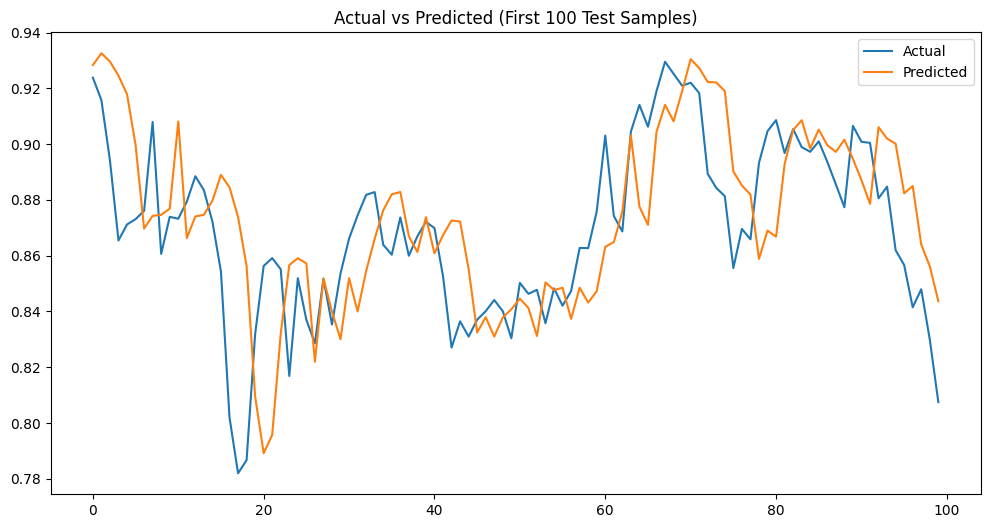

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()
preds_list = []
targets_list = []

print("Starting evaluation on test set...")

with torch.no_grad():
    for price_b, sbert_b, finbert_b, mask_b, sid_b, y_b in test_loader:
        # Move inputs to device
        price_b = price_b.to(device)
        sbert_b = sbert_b.to(device)
        finbert_b = finbert_b.to(device)
        mask_b = mask_b.to(device)
        sid_b = sid_b.to(device)
        y_b = y_b.to(device)

        # Expand stock IDs to sequence length
        sid_seq = sid_b.unsqueeze(1).expand(-1, price_b.size(1))

        # Forward pass
        outputs = model(price_b, sbert_b, finbert_b, mask_b, sid_seq)

        # Collect results
        preds_list.append(outputs.cpu().numpy())
        targets_list.append(y_b.cpu().numpy())

# Concatenate all batches
preds_array = np.concatenate(preds_list).flatten()
targets_array = np.concatenate(targets_list).flatten()

# Calculate Metrics
mse = mean_squared_error(targets_array, preds_array)
mae = mean_absolute_error(targets_array, preds_array)
r2 = r2_score(targets_array, preds_array)

print("\n--- Final Evaluation Metrics ---")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

# Optional: Visualize first 100 points
plt.figure(figsize=(12, 6))
plt.plot(targets_array[:100], label='Actual')
plt.plot(preds_array[:100], label='Predicted')
plt.title("Actual vs Predicted (First 100 Test Samples)")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

print("--- Calculating Naive Baseline Metrics (Persistence Model) ---")
print(f"Baseline Strategy: Predict P(t+{h_val}) will be exactly P(t) (Last known price)\n")

all_naive_preds = []
all_actuals = []

for stock_data in test_data_store:
    prices = stock_data['price'][:, 1] # Close price index

    # We need to reconstruct the exact indices used in the dataset
    # Sequence ends at: start + lookback
    # Target is at: start + lookback + horizon - 1
    # Last known input is at: start + lookback - 1

    n_samples = len(prices) - lookback - h_val + 1
    if n_samples <= 0: continue

    for i in range(n_samples):
        last_known_idx = i + lookback - 1
        target_idx = i + lookback + h_val - 1

        # Naive prediction: Price doesn't change over horizon
        naive_pred = prices[last_known_idx]
        actual = prices[target_idx]

        all_naive_preds.append(naive_pred)
        all_actuals.append(actual)

# Convert to arrays
naive_preds_arr = np.array(all_naive_preds)
actuals_arr = np.array(all_actuals)

# Calculate Metrics
naive_mse = mean_squared_error(actuals_arr, naive_preds_arr)
naive_r2 = r2_score(actuals_arr, naive_preds_arr)

print(f"Naive Baseline MSE: {naive_mse:.6f}")
print(f"Naive Baseline R2:  {naive_r2:.6f}")
print("\nComparison:")
print(f"Model R2 (from previous step): {r2:.6f}")

if naive_r2 > 0.95:
    print("\nInterpretation: The high R2 is driven by the strong trend in the data.")
    print("Most of the variance is explained simply by the current price level.")
else:
    print("\nInterpretation: The model is significantly outperforming the trend.")

--- Calculating Naive Baseline Metrics (Persistence Model) ---
Baseline Strategy: Predict P(t+3) will be exactly P(t) (Last known price)

Naive Baseline MSE: 0.010306
Naive Baseline R2:  0.995917

Comparison:
Model R2 (from previous step): 0.994584

Interpretation: The high R2 is driven by the strong trend in the data.
Most of the variance is explained simply by the current price level.


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(targets_array[:100], label='Actual')
plt.plot(preds_array[:100], label='Predicted')
plt.title("Actual vs Predicted (First 100 Test Samples)")
plt.legend()
plt.show()

Generating Actual vs Predicted plots for each stock in the test set (Horizon = 3 days)...



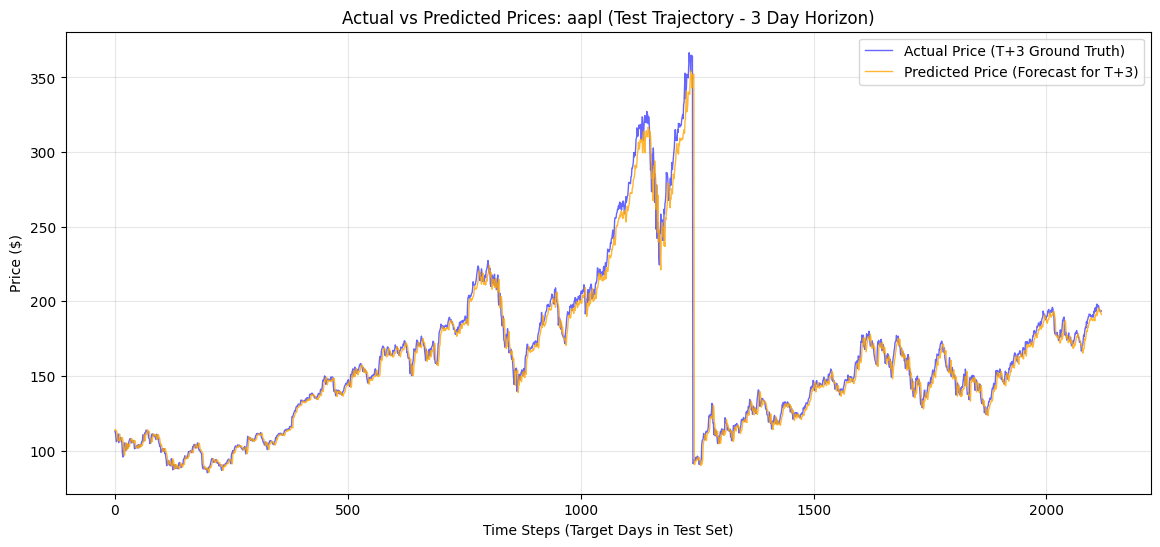

aapl - MSE: 133.0293



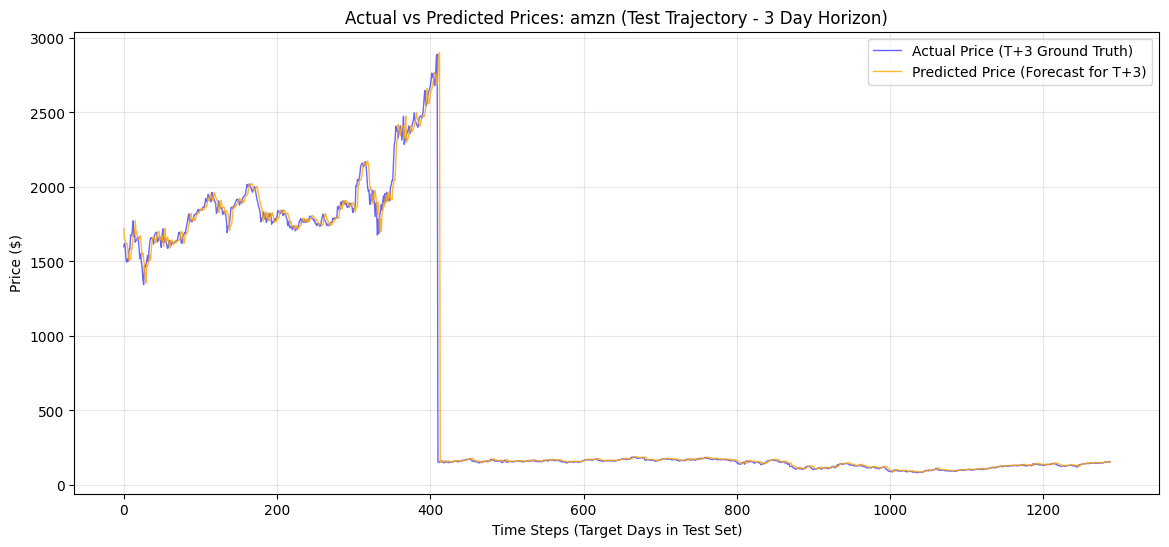

amzn - MSE: 18248.1135



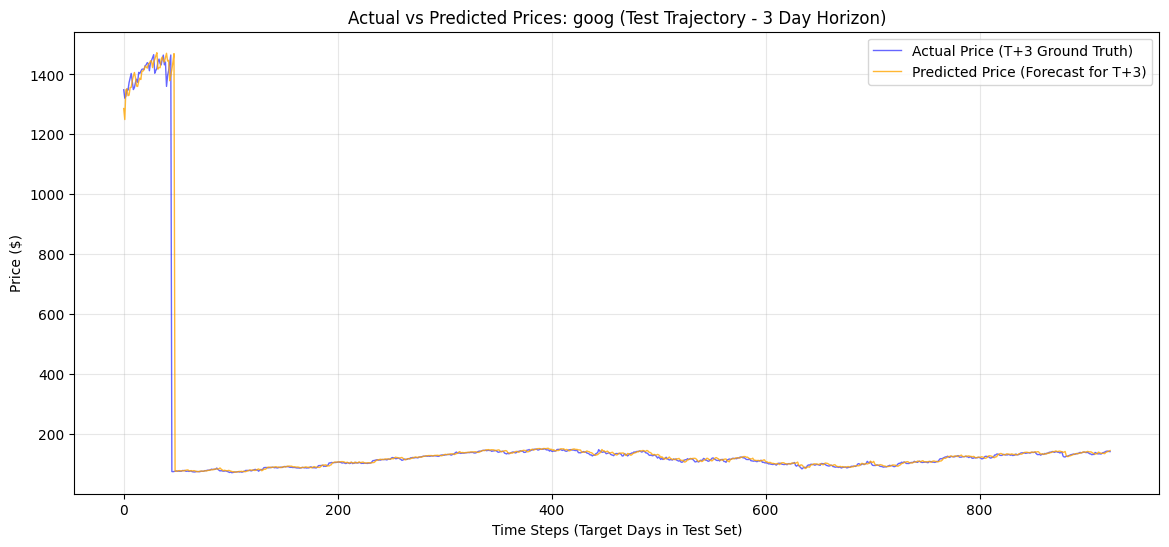

goog - MSE: 6161.8137



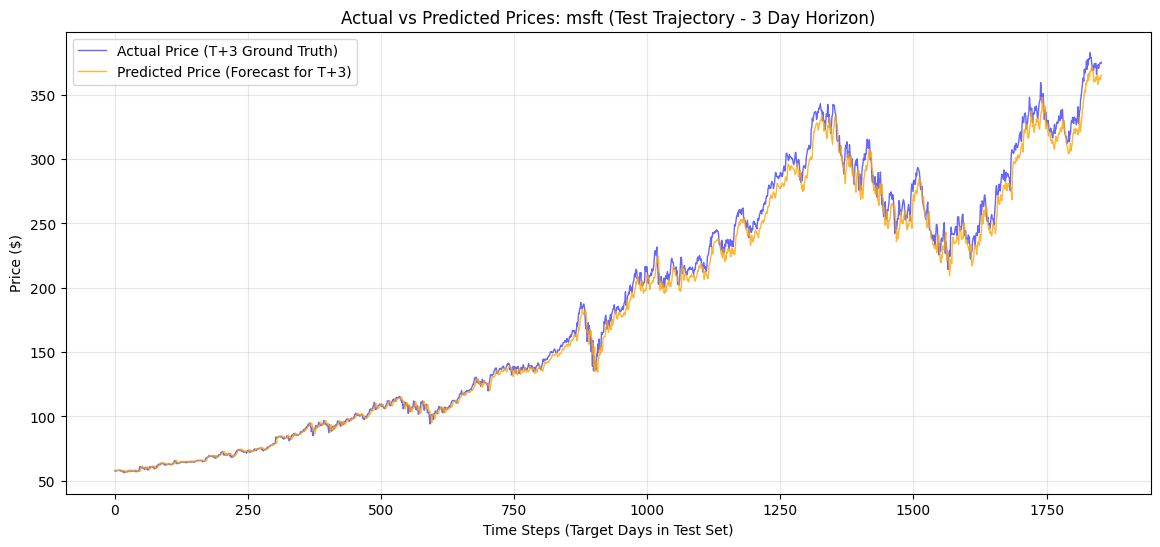

msft - MSE: 66.7390



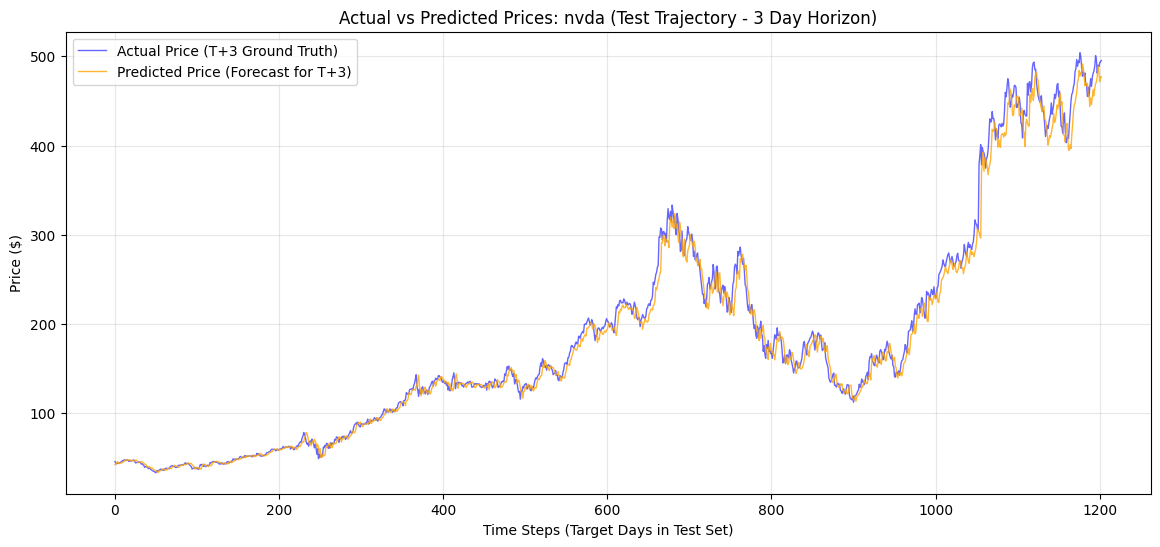

nvda - MSE: 163.7061



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration
price_col_idx = 1  # Close price is at index 1 in the scaler (Open, Close, Volume)
current_idx = 0
# Ensure horizon is used correctly (fallback to 3 if not in scope, though it should be)
h_val = horizon if 'horizon' in globals() else 3

print(f"Generating Actual vs Predicted plots for each stock in the test set (Horizon = {h_val} days)...\n")

# Iterate through each stock in the test store
for stock_data in test_data_store:
    symbol = stock_data['symbol']

    # Calculate the number of samples for this stock in the test set
    # (Must match the logic in LazyStockDataset)
    n_samples = len(stock_data['price']) - lookback - h_val + 1

    if n_samples <= 0:
        continue

    # Extract the corresponding segment from the flattened predictions/targets arrays
    # Ensure we don't go out of bounds (in case of batch drop_last, though default is False)
    end_idx = min(current_idx + n_samples, len(preds_array))

    pred_segment = preds_array[current_idx : end_idx]
    target_segment = targets_array[current_idx : end_idx]

    # Update index for next stock
    current_idx += n_samples

    # If segment is empty, skip
    if len(pred_segment) == 0:
        continue

    # --- Inverse Scaling ---
    scaler = scalers[symbol]

    # Create dummy arrays with shape (N, 3) to match scaler input
    # We rely on the fact that MinMaxScaler scales columns independently.
    pred_dummy = np.zeros((len(pred_segment), 3))
    pred_dummy[:, price_col_idx] = pred_segment

    target_dummy = np.zeros((len(target_segment), 3))
    target_dummy[:, price_col_idx] = target_segment

    # Inverse transform and select the Close price column
    pred_actual = scaler.inverse_transform(pred_dummy)[:, price_col_idx]
    target_actual = scaler.inverse_transform(target_dummy)[:, price_col_idx]

    # --- Plotting ---
    plt.figure(figsize=(14, 6))
    # Explanation:
    # target_actual[i] is the true price at day (Start + i + Horizon)
    # pred_actual[i] is the model's prediction for that same day (made Horizon days earlier)
    # They are aligned by the 'Target Date'.
    plt.plot(target_actual, label=f'Actual Price (T+{h_val} Ground Truth)', color='blue', alpha=0.6, linewidth=1)
    plt.plot(pred_actual, label=f'Predicted Price (Forecast for T+{h_val})', color='orange', alpha=0.8, linewidth=1)

    plt.title(f"Actual vs Predicted Prices: {symbol} (Test Trajectory - {h_val} Day Horizon)")
    plt.xlabel("Time Steps (Target Days in Test Set)")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print some metrics for this specific stock
    stock_mse = np.mean((target_actual - pred_actual)**2)
    print(f"{symbol} - MSE: {stock_mse:.4f}\n")

In [ ]:
import torch
import pickle

# Define checkpoint path
checkpoint_path = 'model_checkpoint.pth'

print(f"Saving model checkpoint to {checkpoint_path}...")

# Create a dictionary containing all necessary state information
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scalers': scalers,
    'stock_to_idx': stock_to_idx,
    'config': {
        'lookback': lookback,
        'horizon': horizon,
        'sbert_dim': sbert_dim,
        'finbert_dim': finbert_dim,
        'price_dim': price_dim,
        'd_model': 64, # Hardcoded in previous cell, ideal to use variable
        'num_heads': 4,
        'num_layers': 2,
        'dropout': 0.2
    }
}

# Save to file
torch.save(checkpoint, checkpoint_path)
print("Checkpoint saved successfully.")

# Optional: Copy to Drive if mounted for persistence
import os
if os.path.exists('/content/drive/MyDrive'):
    drive_path = '/content/drive/MyDrive/model_checkpoint.pth'
    print(f"Copying to Google Drive: {drive_path}...")
    torch.save(checkpoint, drive_path)
    print("Copied to Drive.")

Saving model checkpoint to model_checkpoint.pth...
Checkpoint saved successfully.


In [ ]:
import torch
import os

# 1. Define Path
load_path = 'model_checkpoint.pth'

if os.path.exists(load_path):
    print(f"Loading checkpoint from {load_path}...")
    # FIX: Set weights_only=False to allow loading sklearn scalers stored in the checkpoint
    checkpoint = torch.load(load_path, map_location=device, weights_only=False)

    # 2. Recover Configuration
    config = checkpoint['config']
    stock_to_idx_loaded = checkpoint['stock_to_idx']
    scalers_loaded = checkpoint['scalers']
    print("Configuration loaded.")

    # 3. Re-initialize Model
    # We derive num_stocks from the saved mapping length
    num_stocks_loaded = len(stock_to_idx_loaded)

    loaded_model = AttentionTimeSeriesTransformer(
        num_stocks=num_stocks_loaded,
        sbert_dim=config['sbert_dim'],
        finbert_dim=config['finbert_dim'],
        price_dim=config['price_dim'],
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        output_dim=1,
        dropout=config['dropout']
    ).to(device)

    # 4. Load Weights
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    print("Model weights loaded successfully.")

    # 5. Test Run (Verification)
    print("Verifying loaded model with Test Loader...")

    if 'test_loader' in globals():
        criterion = torch.nn.MSELoss()
        running_loss = 0.0
        count = 0

        with torch.no_grad():
            for price_b, sbert_b, finbert_b, mask_b, sid_b, y_b in test_loader:
                price_b = price_b.to(device)
                sbert_b = sbert_b.to(device)
                finbert_b = finbert_b.to(device)
                mask_b = mask_b.to(device)
                sid_b = sid_b.to(device)
                y_b = y_b.to(device)

                seq_len = price_b.size(1)
                sid_seq = sid_b.unsqueeze(1).expand(-1, seq_len)

                outputs = loaded_model(price_b, sbert_b, finbert_b, mask_b, sid_seq)
                loss = criterion(outputs, y_b)
                running_loss += loss.item() * price_b.size(0)
                count += price_b.size(0)

        print(f"Verification Test Loss (MSE): {running_loss / count:.6f}")
    else:
        print("Warning: 'test_loader' not found in memory. Skipping verification loop.")

else:
    print(f"Error: Checkpoint file {load_path} not found.")

Loading checkpoint from model_checkpoint.pth...
Configuration loaded.
Model weights loaded successfully.
Verifying loaded model with Test Loader...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Verification Test Loss (MSE): 0.013669
